## **Mount implementation folder in google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/FYP/Implementation/data
! ls

/content/drive/.shortcut-targets-by-id/1MkC_V0CRXkQ-OsCBxF38m1Sku4w4s3TR/FYP/Implementation/data
encoded-data.csv	preprosessing-dos.csv	  UNSW-NB15_2.csv
IF_SA.png		selected_columns_all.csv  UNSW-NB15_3.csv
NUSW-NB15_features.csv	SVR-predict-data.csv	  UNSW-NB15_4.csv
OTset.csv		testset.csv
preprocessing.csv	UNSW-NB15_1.csv


## **Load balanced training datset for DOS attacks**

Data = (x_train, y_train)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

#get select columns for training
select_col=pd.read_csv("selected_columns_all.csv", sep=',', on_bad_lines='skip', index_col=False)
col=list(select_col['Worms'])


#create training dataset down sampling
df = pd.read_csv('encoded-data.csv', sep=',', on_bad_lines='skip', index_col=False)
attack_labels = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] + ['attack_cat','Label']


Exploits_attacks = df[df['Worms'] == 1]
Normal_Data = df[df['Label'] == 0]
frames = [Exploits_attacks, Normal_Data]
result = pd.concat(frames)
X=result.drop(labels=attack_labels, axis=1)
Y=result[['Worms']]
X.head()

undersample = RandomUnderSampler(random_state=0)
# fit and apply the transform
X, Y = undersample.fit_resample(X,Y)


x_train,y_train  = shuffle(X[col],Y)


X_train_normalized = preprocessing.normalize(x_train)
X_train_normalized 




array([[2.07411781e-05, 3.57606519e-06, 2.21716042e-05, ...,
        4.56305918e-04, 3.28997998e-05, 9.99999873e-01],
       [8.47305761e-03, 1.68116222e-04, 8.54030410e-03, ...,
        1.51304600e-03, 3.36232445e-04, 9.99872021e-01],
       [3.87943049e-05, 2.67546930e-06, 4.14697742e-05, ...,
        1.01667833e-04, 5.35093860e-06, 9.99999961e-01],
       ...,
       [6.48357707e-05, 1.11785812e-05, 6.93072032e-05, ...,
        2.03450177e-04, 3.57714597e-05, 9.99999749e-01],
       [0.00000000e+00, 6.52173913e-08, 2.76086957e-06, ...,
        0.00000000e+00, 2.17391304e-08, 1.00000000e+00],
       [3.14847806e-02, 6.24698027e-04, 3.17346598e-02, ...,
        5.49734264e-03, 1.24939605e-03, 9.98232552e-01]])

## **Create Test Set for DOS attacks**

Data = (x_test_DOS_normalized, y_test)

In [4]:
import pandas as pd
import numpy as np
select_col=pd.read_csv("selected_columns_all.csv", sep=',', on_bad_lines='skip', index_col=False)

columns=list(select_col['Worms'])

test_data =pd.read_csv("testset.csv", sep=',', on_bad_lines='skip', index_col=False)
attack_labels = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] + ['attack_cat','Label']
attack_categories = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] 

Exploits_attacks  = test_data[test_data['attack_cat'] == 'Worms']
# print(DoS_attacks.shape)
Normal_Data = test_data[test_data['Label'] == 0]
# print(Normal_Data.shape)

frames = [Exploits_attacks , Normal_Data]
result = pd.concat(frames)
X=result.drop(labels=['attack_cat', 'Label'], axis=1)
Y=result[['Label']]
X.head()

x_test,y_test  = shuffle(X[columns],Y)

x_test = x_test.replace('-','')
x_test = x_test.replace(r'^\s*$', np.nan, regex=True)

#delete raws with missing values
for i in x_test.columns.values.tolist():
  i = x_test.loc[x_test[i].isnull()].index
  x_test = x_test.drop(index=list(i))
  y_test = y_test.drop(index=list(i))

percent_missing = x_test.isnull().sum()
missing_value_df = pd.DataFrame({'column_name': x_test.columns, 'count_missing': percent_missing, 'To be dropped': (percent_missing > 45)})
# print(missing_value_df)

x_test.head()
#encode the data
from sklearn.preprocessing import LabelEncoder

# replace hex with int
# x_test['sport'] = x_test['sport'].astype(str).apply(int, base=16)
# x_test['dsport'] = x_test['dsport'].astype(str).apply(int, base=16)

# #Create an instance of Label-encoder
labelencoder = LabelEncoder() 

# # encode columns consists with strings
x_test['srcip'] = labelencoder.fit_transform(x_test['srcip'])
x_test['dstip'] = labelencoder.fit_transform(x_test['dstip'])
x_test['proto'] = labelencoder.fit_transform(x_test['proto'])
x_test['state'] = labelencoder.fit_transform(x_test['state'])

X_test_normalized = preprocessing.normalize(x_test) 


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**Random Forrest Regression**

In [5]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#training data
x = np.array(X_train_normalized)
y = np.array(y_train)


# Number of trees in random forest
n_estimators = [2, 4, 8, 16, 32, 64, 100]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2,3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}




 # create regressor object
regressor = GridSearchCV(RandomForestRegressor(random_state=0),param_grid,return_train_score=False)

# fit the regressor with x and y data
regressor.fit(x, y)


df = pd.DataFrame(regressor.cv_results_)
df

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007545,0.003787,0.001461,0.000668,True,2,auto,1,2,2,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.547703,0.499413,0.908134,0.830915,0.596666,0.676566,0.162370,328
1,0.008746,0.000438,0.001364,0.000164,True,2,auto,1,2,4,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.582384,0.563562,0.887627,0.820994,0.664244,0.703762,0.129228,322
2,0.014217,0.000667,0.001406,0.000068,True,2,auto,1,2,8,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.597390,0.597728,0.891352,0.813345,0.690224,0.718008,0.117410,296
3,0.025471,0.001359,0.003012,0.001384,True,2,auto,1,2,16,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.652583,0.617989,0.895284,0.822679,0.704297,0.738567,0.104634,233
4,0.051429,0.003316,0.003731,0.000413,True,2,auto,1,2,32,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.649897,0.658351,0.890571,0.831793,0.701145,0.746351,0.097150,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,0.009265,0.000541,0.001644,0.000057,False,4,sqrt,2,5,8,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.646169,0.763336,0.903081,0.925973,0.799382,0.807588,0.101208,127
332,0.017291,0.003580,0.002702,0.000705,False,4,sqrt,2,5,16,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.674337,0.776070,0.921705,0.924832,0.819983,0.823385,0.094259,111
333,0.035317,0.008656,0.003396,0.000545,False,4,sqrt,2,5,32,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.695715,0.793749,0.923121,0.935895,0.843084,0.838313,0.088383,84
334,0.056477,0.003850,0.004933,0.000099,False,4,sqrt,2,5,64,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.698253,0.797226,0.927109,0.941440,0.845057,0.841817,0.089229,69


In [6]:
df[['param_bootstrap', 	'param_max_depth', 	'param_max_features', 	'param_min_samples_leaf', 	'param_min_samples_split', 	'param_n_estimators','mean_test_score']]

,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score
0,True,2,auto,1,2,2,0.676566
1,True,2,auto,1,2,4,0.703762
2,True,2,auto,1,2,8,0.718008
3,True,2,auto,1,2,16,0.738567
4,True,2,auto,1,2,32,0.746351
...,...,...,...,...,...,...,...
331,False,4,sqrt,2,5,8,0.807588
332,False,4,sqrt,2,5,16,0.823385
333,False,4,sqrt,2,5,32,0.838313
334,False,4,sqrt,2,5,64,0.841817


In [7]:
regressor.best_params_

{'bootstrap': False,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 32}

**Train the model**

In [8]:
from sklearn.ensemble import RandomForestRegressor

#training data
x = np.array(X_train_normalized)
y = np.array(y_train)


 # create regressor object
regressor = RandomForestRegressor(bootstrap=False,max_depth=4,max_features= 'auto',min_samples_leaf=2,min_samples_split=2,n_estimators=32)

# fit the regressor with x and y data
regressor.fit(x, y)

y_pred = regressor.predict(x)


<ipython-input-8-2f7ea43d9ddc>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x, y)


In [9]:
from sklearn.metrics import accuracy_score

for i in range(1,100):
  y_predict_class = [1 if p > i/100 else 0 for p in y_pred]
  print("Accuracy when threshould = ",i/100, round(accuracy_score(y, y_predict_class), 6))

Accuracy when threshould =  0.01 0.961165
Accuracy when threshould =  0.02 0.961165
Accuracy when threshould =  0.03 0.961165
Accuracy when threshould =  0.04 0.961165
Accuracy when threshould =  0.05 0.961165
Accuracy when threshould =  0.06 0.961165
Accuracy when threshould =  0.07 0.961165
Accuracy when threshould =  0.08 0.961165
Accuracy when threshould =  0.09 0.966019
Accuracy when threshould =  0.1 0.966019
Accuracy when threshould =  0.11 0.966019
Accuracy when threshould =  0.12 0.970874
Accuracy when threshould =  0.13 0.970874
Accuracy when threshould =  0.14 0.970874
Accuracy when threshould =  0.15 0.970874
Accuracy when threshould =  0.16 0.970874
Accuracy when threshould =  0.17 0.970874
Accuracy when threshould =  0.18 0.970874
Accuracy when threshould =  0.19 0.970874
Accuracy when threshould =  0.2 0.970874
Accuracy when threshould =  0.21 0.980583
Accuracy when threshould =  0.22 0.980583
Accuracy when threshould =  0.23 0.980583
Accuracy when threshould =  0.24 0.9

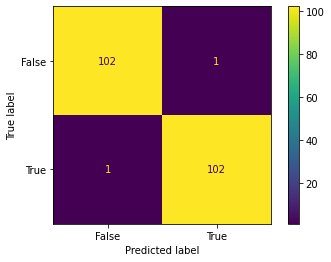

In [10]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

threshould =0.5

y_predict_class = [1 if p > threshould else 0 for p in y_pred]
confusion_matrix = metrics.confusion_matrix(y, y_predict_class)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 


**Test Set Accuracy**

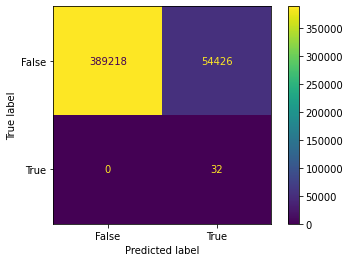

Accuracy when threshould =  0.6 0.877329


In [11]:
x_test_array = np.array(X_test_normalized)
y_test_array = np.array(y_test)
y_pred_test_set = regressor.predict(x_test_array)


threshould =0.6


y_predict_test_set_class = [1 if p > threshould else 0 for p in y_pred_test_set]
confusion_matrix = metrics.confusion_matrix(y_test_array, y_predict_test_set_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 

print("Accuracy when threshould = ",threshould, round(accuracy_score(y_test_array, y_predict_test_set_class), 6))